In [1]:
import tensorflow as tf
from tensorflow import keras
print("Number of GPUS : ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Number of GPUS :  1


True

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from tqdm import tqdm
import glob
import cv2
from keras.layers import Conv2D, Dropout

In [40]:
input_t = keras.Input(shape=(224, 224, 3))

resnet = keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input_t)

In [41]:
for layer in resnet.layers:
    layer.trainable = False

In [42]:
x = Flatten()(resnet.output)

In [43]:
folders = glob.glob('smote_data/*')

In [47]:
model = Sequential()

# for layer in resnet.layers:
#     model.add(layer)

model.add(resnet)
    

# model.add(Dropout(0.3))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='additional_layer') )
model.add(Flatten())
model.add(Dense(2, activation='softmax', name='predictions'))

In [48]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [49]:
optimizer = keras.optimizers.Adam(lr=0.000001)

In [50]:
check_point = keras.callbacks.ModelCheckpoint(filepath = 'cifar10.h5', monitor="val_acc", mode = "max", save_best_only=True,)

In [51]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [52]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [53]:
train_path = 'smote_data'
test_path = '../dataset/chest_xray/test'

In [54]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 7750 images belonging to 2 classes.


In [55]:
training_set.class_indices

{'normal': 0, 'pneumonia': 1}

In [56]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [57]:
r = model.fit(training_set,validation_data=test_set,epochs=100,steps_per_epoch=len(training_set),validation_steps=len(test_set), callbacks=[check_point])

Epoch 1/100
243/243 [==============================] - 309s 1s/step - loss: 0.7033 - accuracy: 0.5071 - val_loss: 0.6817 - val_accuracy: 0.6490
Epoch 2/100
243/243 [==============================] - 117s 482ms/step - loss: 0.6864 - accuracy: 0.5867 - val_loss: 0.6843 - val_accuracy: 0.6202
Epoch 3/100
243/243 [==============================] - 127s 520ms/step - loss: 0.6796 - accuracy: 0.6050 - val_loss: 0.6753 - val_accuracy: 0.6811
Epoch 4/100
243/243 [==============================] - 136s 557ms/step - loss: 0.6739 - accuracy: 0.6632 - val_loss: 0.6574 - val_accuracy: 0.7196
Epoch 5/100
243/243 [==============================] - 141s 581ms/step - loss: 0.6680 - accuracy: 0.6763 - val_loss: 0.6520 - val_accuracy: 0.7484
Epoch 6/100
243/243 [==============================] - 128s 525ms/step - loss: 0.6623 - accuracy: 0.7009 - val_loss: 0.6553 - val_accuracy: 0.7388
Epoch 7/100
243/243 [==============================] - 131s 540ms/step - loss: 0.6567 - accuracy: 0.6933 - val_loss: 0.64

In [58]:
model.save("cifar10.h5")

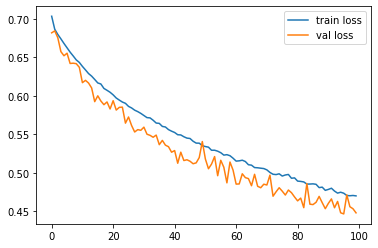

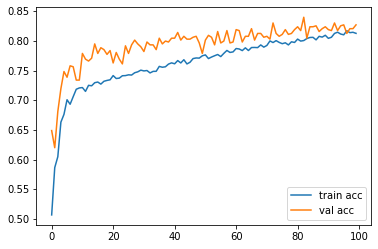

<Figure size 432x288 with 0 Axes>

In [59]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']